In [1]:
%matplotlib inline
import numpy as np
import pylab
import nengo
import nengo_solver_dales
import pandas
import seaborn
import pytry

c:\users\terry\py3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [9]:

from nengo.utils.least_squares_solvers import rmses

class SpeedTrial(pytry.PlotTrial):
    def params(self):
        self.param('number of pre neurons', N_pre=100)
        self.param('number of post neurons', N_post=100)
        self.param('proportion inhibitory', p_inh=0.2)
        self.param('dimensions', D=3)
        self.param('amount of regularization', reg=0.1)
        self.param('noise for testing', test_noise=0.1)
        self.param('sparsity', sparsity=0.0)
        
    def evaluate(self, p, plt):
        p_inh = 0.2
        model = nengo.Network()
        with model:
            a = nengo.Ensemble(n_neurons=p.N_pre, dimensions=p.D)
            b = nengo.Ensemble(n_neurons=p.N_post, dimensions=p.D)
            conn = nengo.Connection(a, b, solver=nengo_solver_dales.DalesL2(
                                                    reg=p.reg, p_inh=p.p_inh,
                                                    sparsity=p.sparsity))
        sim = nengo.Simulator(model, progress_bar=p.verbose)

        x_train, a_train = nengo.utils.ensemble.tuning_curves(a, sim, inputs=sim.data[a].eval_points)
        x_test, a_test = nengo.utils.ensemble.tuning_curves(a, sim, inputs=a.eval_points.sample(x_train.shape[0], d=p.D))
        enc = sim.data[b].scaled_encoders
        target_train = np.dot(x_train, enc.T)
        target_test = np.dot(x_test, enc.T)

        w = sim.data[conn].weights

        a_train = a_train + np.random.normal(scale=a_train.max()*p.test_noise, size=a_train.shape)
        a_test = a_test + np.random.normal(scale=a_test.max()*p.test_noise, size=a_test.shape)
        
        actual_train = np.dot(a_train, w.T)
        actual_test = np.dot(a_test, w.T)

        rms_train = np.mean(rmses(a_train, w.T, target_train))
        rms_test = np.mean(rmses(a_test, w.T, target_test))

        if plt:
            pylab.subplot(1, 2, 1)
            plt.scatter(target_train, actual_train, s=1)
            pylab.title('training')
            pylab.subplot(1, 2, 2)
            plt.scatter(target_test, actual_test, s=1)
            pylab.title('testing')

        return dict(rms_train=rms_train,
                    rms_test=rms_test,
                    time=sim.data[conn].solver_info['time'])


A quick test to make sure the model runs

running SpeedTrial#20181004-221716-16cd6697


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

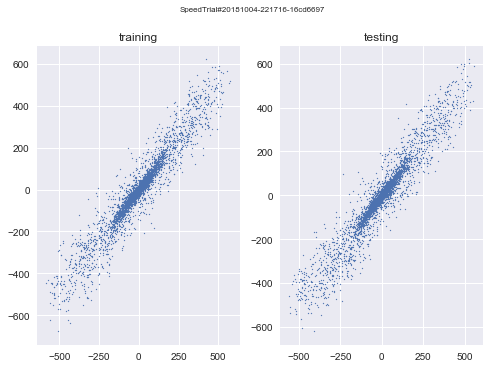

seed = 1
N_pre = 100
N_post = 13
p_inh = 0.2
D = 3
reg = 0.1
test_noise = 0.1
sparsity = 0.5
rms_test = 10.160665090377034
rms_train = 10.144740705429705
time = 0.003990888595581055


{'rms_test': 10.160665090377034,
 'rms_train': 10.144740705429705,
 'time': 0.003990888595581055}

In [10]:
SpeedTrial().run(plt=True, reg=0.1, sparsity=0.5, N_pre=100, N_post=13)

Vary the number of pre-synaptic neurons

In [53]:
for seed in range(5):
    print(seed)
    for N_pre in [10, 20, 50, 100, 200, 500]:
        SpeedTrial().run(reg=0.1, N_pre=N_pre, data_dir='N_pre', seed=seed, verbose=False)

0
1
2
3
4


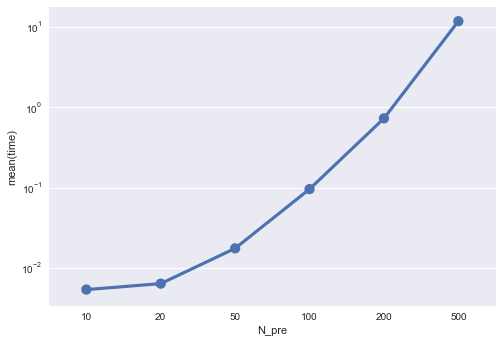

In [11]:
df = pandas.DataFrame(pytry.read('N_pre'))
seaborn.pointplot('N_pre', 'time', data=df)
pylab.yscale('log')


Vary the number of post-synaptic neurons

In [55]:
for seed in range(5):
    print(seed)
    for N_post in [10, 20, 50, 100, 200, 500, 1000]:
        SpeedTrial().run(reg=0.1, N_pre=100, N_post=N_post, data_dir='N_post', seed=seed, verbose=False)

0
1
2
3
4


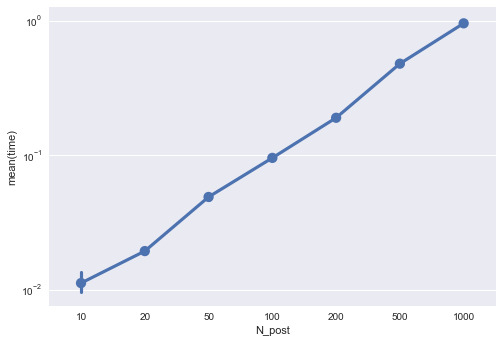

In [12]:
df = pandas.DataFrame(pytry.read('N_post'))
seaborn.pointplot('N_post', 'time', data=df)
pylab.yscale('log')


Now let's very the sparsity and plot time and error

In [8]:
for seed in range(5):
    print(seed)
    for N_pre in [500, 1000]:
        for sparsity in [0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95]:
            SpeedTrial().run(reg=0.1, N_pre=N_pre, sparsity=sparsity,
                             data_dir='sparsity', seed=seed, verbose=False)

0
1
2
3
4


In [14]:
for seed in range(5):
    print(seed)
    for N_pre in [5000]:
        for sparsity in [0.9, 0.95, 0.97, 0.99]:
            SpeedTrial().run(reg=0.1, N_pre=N_pre, sparsity=sparsity,
                             data_dir='sparsity', seed=seed, verbose=False)

0
1
2
3
4


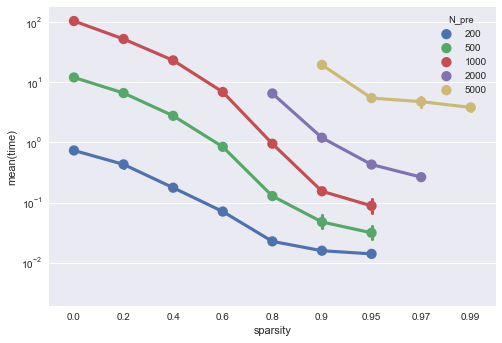

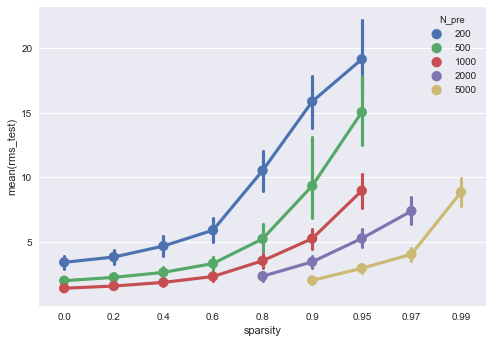

In [13]:
df = pandas.DataFrame(pytry.read('sparsity'))
seaborn.pointplot('sparsity', 'time', hue='N_pre', data=df)
pylab.yscale('log')
pylab.figure()
seaborn.pointplot('sparsity', 'rms_test', hue='N_pre', data=df)
